In [115]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [116]:
data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

In [117]:
import random
target = data['Exited']
print('Exited == 0:',sum(target == 0) / len(target))
print('Exited == 1:',sum(target == 1) / len(target))

target_0 = data[target == 0]
target_1 = data[target == 1]
idxes = random.sample(range(0,len(target_0)), len(target_1))
target_0 = target_0.iloc[idxes]

data_balanced = pd.concat((target_0, target_1), axis=0)
data_balanced = data_balanced.sample(frac=1)
#data_balanced = data
print(len(data_balanced))

Exited == 0: 0.7884011779390914
Exited == 1: 0.21159882206090866
69842


In [118]:
data_balanced = data

In [119]:
y_train = data_balanced['Exited']
y_train_source = y_train.copy()
X_train = data_balanced.drop(['Exited','id', 'CustomerId', 'Surname'], axis = 1)

In [120]:
import matplotlib.pyplot as plt
def plot_feature_hists():
    fig, ax = plt.subplots(len(X_train.columns),1, figsize=(10,50))
    for idx, col in enumerate(X_train.columns):
        ax[idx].hist(X_train[col][y_train == 1], alpha=0.5, label='exited', bins=50)
        ax[idx].hist(X_train[col][y_train == 0], alpha=0.5, label='NOT exited', bins=50)
        ax[idx].set_title(col)
        ax[idx].legend()

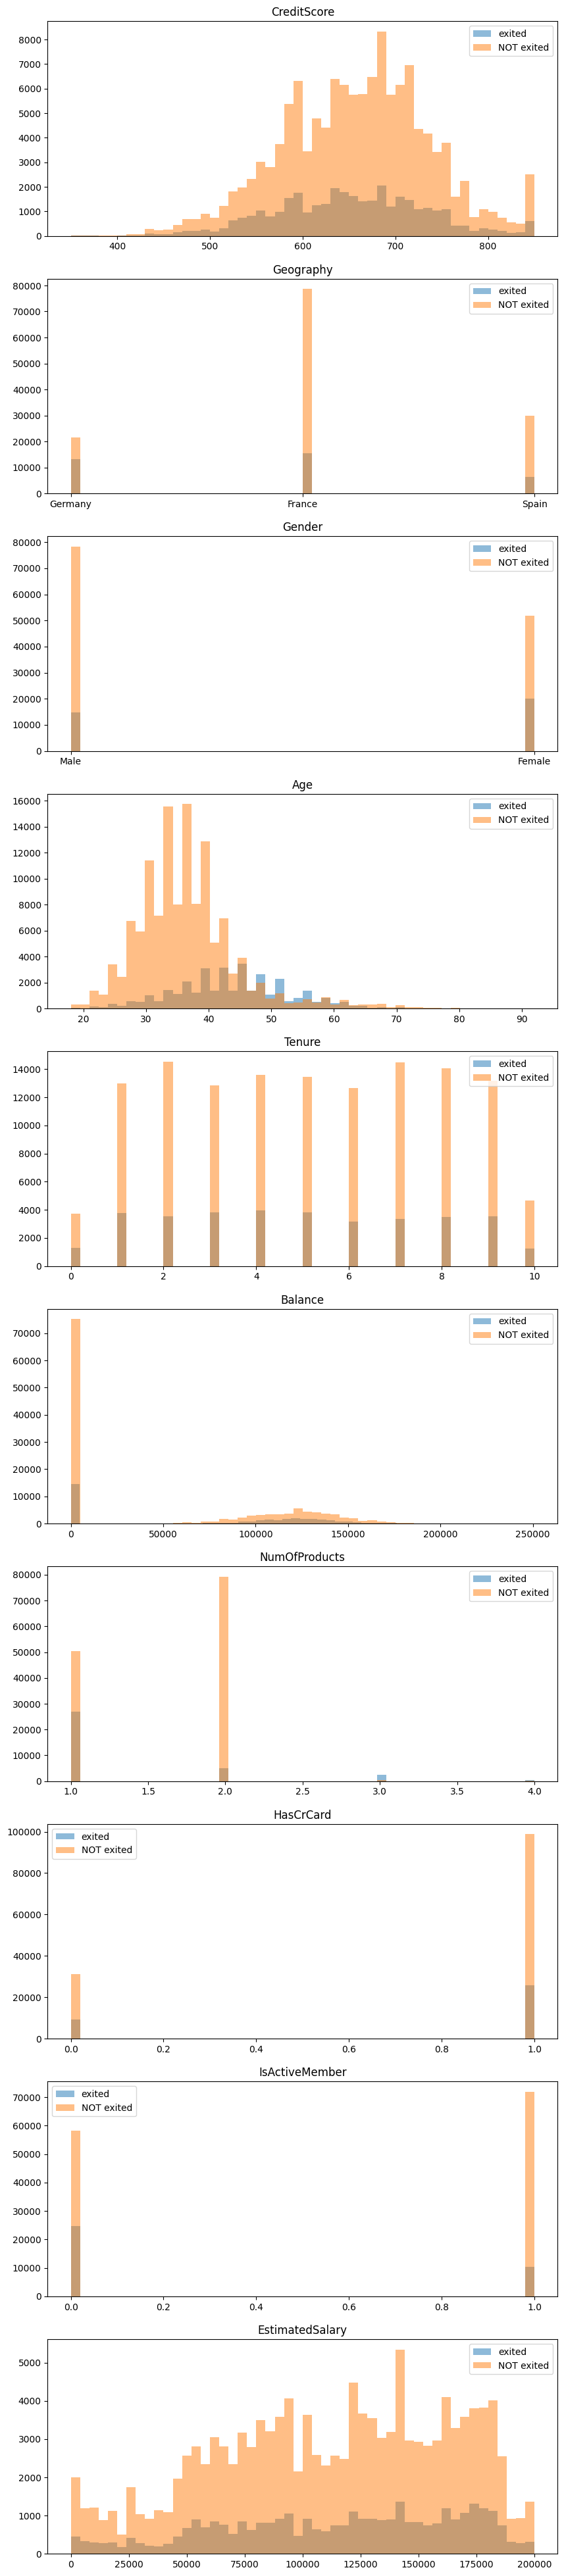

In [121]:
plot_feature_hists()

In [122]:
def encode(X):
    print(X.dtypes)
    new =  pd.get_dummies(X, dtype=np.int64)
    new = new.drop(['Gender_Male','Geography_Spain'], axis = 1 )
    print(new.dtypes)
    
    return new

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
def normalize(X):
    ms = MinMaxScaler()
    to_ret = X.copy()
    to_ret[X.columns] = ms.fit_transform(X)
    return to_ret

In [124]:
#??????
def add_IsBalance0(X):
    #is balance 0
    X['IsBalance0'] = np.int64(X['Balance'] == 0)
    print(X['Balance'] [ X['Balance'] == 0])
    X.loc[X['Balance'] == 0,'Balance'] = np.nan
    
    return X

In [125]:
#BAD IDEA
def add_CreditScoreEstimatedSalary(X):
    
    X['CreditSalary'] = X['CreditScore'] - X['EstimatedSalary']
    return X

In [126]:
#BAD IDEA
def merge_nation_balance(X):
    
    X['GermanyBalance0'] = np.int64(X['IsBalance0'] * X['Geography_Germany'])
    X['FranceBalance0'] = np.int64(X['IsBalance0'] * X['Geography_France'])
    
    
    return X

In [127]:
from sklearn.model_selection import train_test_split
X_train_encoded = encode(X_train)
X_train_encoded_normalized = normalize(X_train_encoded)
y_train = data_balanced['Exited']
X_train_encoded_normalized,X_val, y_train, y_val = train_test_split(X_train_encoded_normalized, y_train, test_size=0.3, 
                                                                   stratify=y_train)

X_train_encoded_normalized.head()

CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object
CreditScore            int64
Age                  float64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard            float64
IsActiveMember       float64
EstimatedSalary      float64
Geography_France       int64
Geography_Germany      int64
Gender_Female          int64
dtype: object


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Gender_Female
94651,0.224,0.418919,0.9,0.000000,0.333333,1.0,1.0,0.322078,1.0,0.0,1.0
146766,0.766,0.216216,0.3,0.463648,0.000000,1.0,0.0,0.662341,0.0,1.0,1.0
105591,0.848,0.297297,0.6,0.370738,0.000000,1.0,0.0,0.912688,1.0,0.0,1.0
53981,0.748,0.175676,0.8,0.000000,0.333333,0.0,1.0,0.362288,1.0,0.0,0.0
127793,0.602,0.283784,0.9,0.439848,0.000000,1.0,1.0,0.806840,0.0,1.0,1.0


<Axes: >

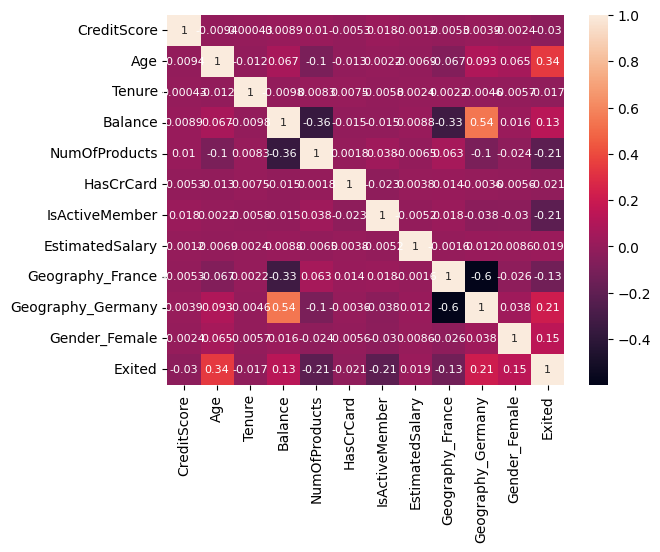

In [128]:
import seaborn as sns
sns.heatmap(pd.concat((X_train_encoded_normalized, y_train),axis=1).corr(), annot=True, fmt=".2g",annot_kws={"fontsize":8})

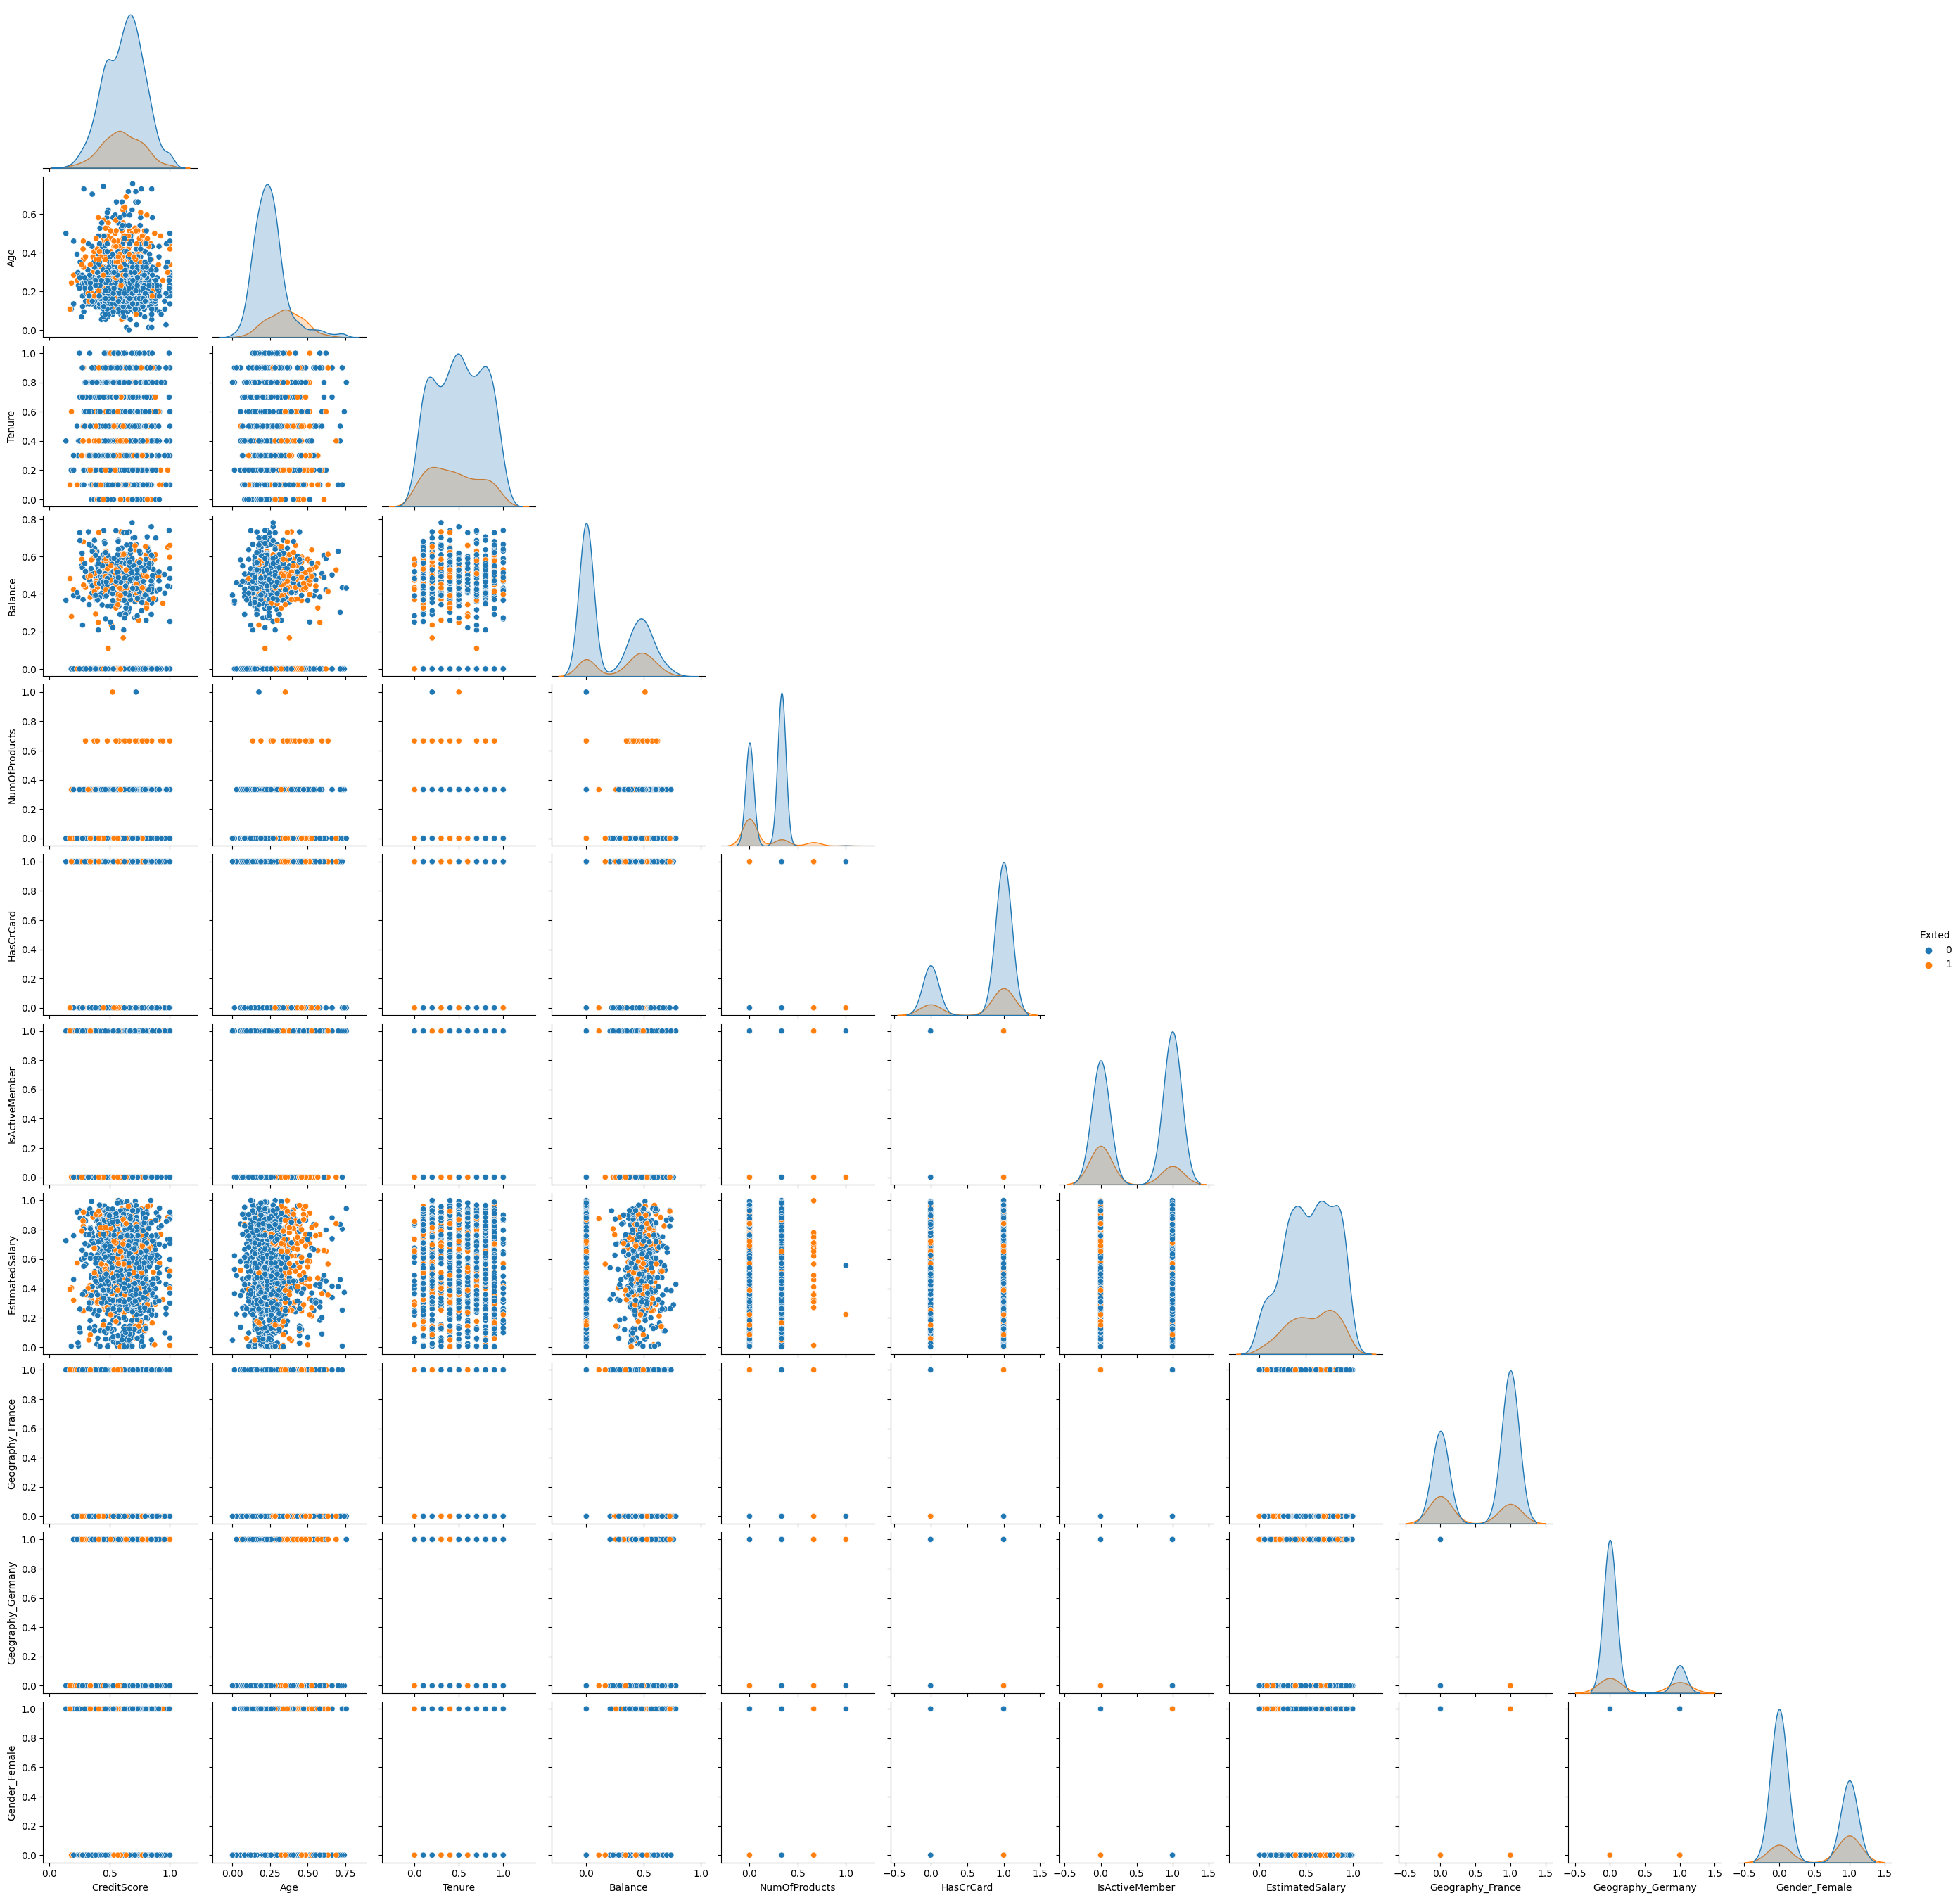

In [129]:
import seaborn as sns
sns.pairplot(pd.concat((X_train_encoded_normalized,y_train), axis=1).sample(frac=.01), hue='Exited', corner=True)


In [134]:

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier

def train_model(model_type,X_train, y_train):
    if model_type == 'rf':
        rf = RandomForestClassifier(n_estimators=1000,max_depth=6)
        rf.fit(X_train, y_train)
        model = rf
        
        
    elif model_type == 'lgb':
        #max_depth=5,n_estimators=1500,learning_rate=0.007  
        lgb = LGBMClassifier(max_depth=5,n_estimators=1500,learning_rate=0.007  )
        params = {'max_depth':[4,5],'n_estimators':[2000,2500,3000], 'learning_rate':[0.05,0.007]}
        cv = GridSearchCV(lgb, param_grid=params, scoring = 'roc_auc')
        lgb.fit(X_train, y_train)
        model = lgb
        
    elif model_type == 'xgb':
        #max_depth=5,n_estimators=1500,learning_rate=0.007  
        xgb = XGBClassifier(max_depth=5,learning_rate=0.007, n_estimators=2500  )
        params = {'max_depth':[4,5],'n_estimators':[2000,2500,3000], 'learning_rate':[0.05,0.007]}
        cv = GridSearchCV(xgb, param_grid=params, scoring = 'roc_auc')
        xgb.fit(X_train, y_train)
        model = xgb
        
    elif model_type == 'svm':
        model = SVC(C=1.0, kernel='rbf', probability=True,max_iter=1500)
        
    elif model_type == 'knn':
        knn = KNeighborsClassifier(n_neighbors=25)
        #params = {'n_neighbors':[20,30]}
        #cv = GridSearchCV(knn, param_grid=params, scoring = 'roc_auc')
        knn.fit(X_train, y_train)
        #print('a')
        model = knn
        
    else:
        assert 'Such model type is not provided'
    
    #model.fit(X_train, y_train)
    pred = model.predict_proba(X_train)
    
    print('train AUC:',roc_auc_score(y_train,pred[:, 1]))

    return model

In [140]:
from catboost import CatBoostClassifier
def train_cat_boost(X_train, y_train):
    X_train['HasCrCard'] = X_train['HasCrCard'] .astype(np.int64)
    X_train['IsActiveMember'] = X_train['IsActiveMember'] .astype(np.int64)
    X_train,X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, 
                                                                   stratify=y_train)
    model = CatBoostClassifier(
        iterations=2500, 
        learning_rate=0.01, 
        depth = 4
        #loss_function='CrossEntropy'
    )
    
    cat_features  = ['Gender', 'Geography','IsActiveMember', 'HasCrCard']
    model.fit(X_train, y_train, 
            cat_features=cat_features, 
            eval_set=(X_val, y_val), 
            verbose=False
    )
    
    pred = model.predict_proba(X_train)
    
    print('train AUC:',roc_auc_score(y_train,pred[:, 1]))
    pred = model.predict_proba(X_val)
    print('validation AUC:',roc_auc_score(y_val,pred[:, 1]))
    
    return model

In [141]:

from sklearn.metrics import roc_auc_score
def train_validate_model(model, X_train, y_train, X_val, y_val):
    model_best = train_model(model, X_train, y_train)
    pred = model_best.predict_proba(X_val)[:, 1]
    print('validation AUC:',roc_auc_score(y_val, pred))
    return model_best

In [146]:
#rf = train_validate_model('rf',X_train_encoded_normalized, y_train, X_val, y_val )
#lgb = train_validate_model('lgb',X_train_encoded_normalized, y_train,X_val, y_val )
#xgb = train_validate_model('xgb',X_train_encoded_normalized, y_train, X_val, y_val )
#cboost = train_cat_boost(X_train, y_train_source)
#.drop('Balance', axis=1)
#svm = train_validate_model('svm',X_train_encoded_normalized_cutted, y_train_cutted, X_val, y_val )
#knn = train_validate_model('knn',X_train_encoded_normalized, y_train, X_val, y_val )

train AUC: 0.8848458214667829
validation AUC: 0.8826121230430606
train AUC: 0.8962698079314717
validation AUC: 0.8887187206750405
train AUC: 0.9003665470594703
validation AUC: 0.8884854586349675
train AUC: 0.8915116820944231
validation AUC: 0.8904973302808843


In [101]:
o = zip(cboost.feature_importances_,X_train.columns)
print([*o])

[(1.5279136177133417, 'CreditScore'), (5.525315616590183, 'Geography'), (3.5379428628903007, 'Gender'), (23.13975405833457, 'Age'), (0.6229361662340488, 'Tenure'), (8.621699840657495, 'Balance'), (45.29348298416408, 'NumOfProducts'), (0.5810445222179981, 'HasCrCard'), (9.941541677043253, 'IsActiveMember'), (1.208368654154748, 'EstimatedSalary')]


In [17]:
#print(knn.get_params())

print(lgb.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.007, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [ ]:
lgb.get_params()

In [147]:
from sklearn.ensemble import StackingClassifier


#xgb = XGBClassifier(max_depth=5,learning_rate=0.007, n_estimators=2500  )
#lgb = LGBMClassifier(max_depth=5,n_estimators=1500,learning_rate=0.007  )
#knn = KNeighborsClassifier(n_neighbors=25)

X_train_stacking,X_val_stacking, y_train_stacking, y_val_stacking = train_test_split(X_val, y_val, test_size=0.4, 
                                                                   stratify=y_val)

stacking_clf = StackingClassifier(estimators=[('lgb',lgb),('xgb', xgb), ('cb', cboost), ('rf', rf)], cv='prefit')
stacking_clf.fit(X_train_stacking, y_train_stacking)
pred = stacking_clf.predict_proba(X_val_stacking)[:, 1]
print('validation AUC:',roc_auc_score(y_val_stacking, pred))

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=1]=0.12162162162162166 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


import numpy as np, scipy.stats as st
def find_and_remove_potential_outliers(X, y, label):
    nb = NearestNeighbors(n_neighbors=10)
    df = pd.concat((X,y), axis=1)
    #print(X[y==label].head())
    df = df[y==label]
    df = df.reset_index(drop=True)
    
    sl = df.drop('Exited', axis=1)
    y = df.Exited
    nb.fit(sl.drop(['EstimatedSalary','Balance'], axis=1))
    dist, idxs = nb.kneighbors(sl.drop(['EstimatedSalary','Balance'], axis=1))
    #print(np.in1d(idxs[:,0],sl.index ))
    print(max(idxs[:,0]), np.sort(sl.index))

    dist_sum = dist.sum(axis=1)
    dist_sum = np.sort(dist_sum)
    th_dist = dist_sum[np.int64(0.95 * len(dist_sum))]
    #print(th_dist)
    potential_outliers = idxs[dist_sum >th_dist] [:,0]  #distance to the narest neighbour > 0.3
    #print(len(potential_outliers))
    return sl.drop(potential_outliers), y.drop(potential_outliers)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

#NO SENSE
import numpy as np, scipy.stats as st
def find_and_remove_potential_outliers_by_DBSCAN(X, y, label):
    #nb = NearestNeighbors(n_neighbors=10)
    df = pd.concat((X,y), axis=1)
    #print(X[y==label].head())
    df = df[y==label]
    df = df.reset_index(drop=True)
    db = DBSCAN(eps = 0.25,min_samples = 40)
    sl = df.drop('Exited', axis=1)
    y = df.Exited
    model = db.fit(sl.drop(['EstimatedSalary','Balance'], axis=1))
    l = model.labels_
    #print(sum(l==-1), np.unique(l))
    
    potential_outliers = (l == -1).nonzero()[0]
    #print(len(potential_outliers))
    print(potential_outliers)
    return sl.drop(potential_outliers), y.drop(potential_outliers)
    #return l

In [ ]:
lab = find_and_remove_potential_outliers_by_DBSCAN(X_train_encoded_normalized, y_train, label=0)

In [ ]:
print(sum(lab==-1), np.unique(lab))

In [ ]:
X_potential_out_0, y_potential_out_0 = find_and_remove_potential_outliers(X_train_encoded_normalized, y_train, label=0)
X_potential_out_1, y_potential_out_1 = find_and_remove_potential_outliers(X_train_encoded_normalized, y_train, label=1)



In [ ]:
#print(X_potential_out_0.shape)
X_train_encoded_normalized_cutted = pd.concat((X_potential_out_0,X_potential_out_1), axis=0)
y_train_cutted = pd.concat((y_potential_out_0,y_potential_out_1), axis=0)

df = pd.concat((X_train_encoded_normalized_cutted,y_train_cutted ), axis=1)
new_df = df.sample(frac=1)

y_train_cutted = new_df.Exited
X_train_encoded_normalized_cutted = new_df.drop('Exited', axis=1)

print(y_train_cutted.shape, X_train_encoded_normalized_cutted.shape)

In [ ]:
X_train_encoded_normalized_cutted[y_train_cutted==1].describe()


In [ ]:
X_train_encoded_normalized[y_train==1].describe()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(X_train_encoded_normalized.columns),1, figsize=(10,50))
for idx, col in enumerate(X_train_encoded_normalized.columns):
    ax[idx].boxplot(X_train_encoded_normalized[col][y_train == 1])
    #ax[idx].boxplot(X_train_encoded_normalized[col][y_train == 0])
    ax[idx].set_title(col)
    ax[idx].legend()

In [154]:
def write_results(model, additional_features=None, IsCatBoost=False):
    test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
    ides = test['id']
    test = test.drop(['id', 'CustomerId', 'Surname'], axis = 1)
    if not IsCatBoost:
        test = encode(test)
        test = normalize(test)
    else:
        test['HasCrCard'] = X_train['HasCrCard'] .astype(np.int64)
        test['IsActiveMember'] = X_train['IsActiveMember'] .astype(np.int64)
    if additional_features != None:
        if('IsBalance0' in additional_features):
            test = add_IsBalance0(test)
    #test = pca.transform(test)
    
    preds = model.predict_proba(test)
    
    print(preds)
    df = pd.DataFrame({'id':ides, 'Exited':preds[:,1]})
    
    df.to_csv('/kaggle/working/submission.csv', index=False)
    
write_results(cboost, IsCatBoost=True)

[[0.96132167 0.03867833]
 [0.43519763 0.56480237]
 [0.97379585 0.02620415]
 ...
 [0.99244422 0.00755578]
 [0.69269605 0.30730395]
 [0.81692716 0.18307284]]


<Axes: >

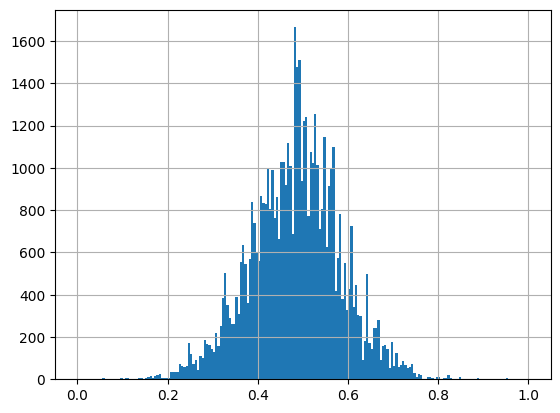

In [155]:
X_train_encoded_normalized.Balance[X_train_encoded_normalized.Balance!=0].hist(bins=200)

In [ ]:
from scipy.stats import pearsonr   

print(pearsonr(X,Y))